## ResNet Autoencoder (AE) for ECAL Endcap Data Quality Monitoring (DQM)

In [1]:
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
from skimage.measure import block_reduce # pip install scikit-image
import mpl_scatter_density
import glob, os, time
from torch.utils.data import Dataset, ConcatDataset, DataLoader, sampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import roc_curve, auc
from utils import *
import warnings
import copy
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(0)

Welcome to JupyROOT 6.24/02


In [2]:
figOutDir = './PLOTS/1_PreProcessing/'
os.system('mkdir -p {}'.format(figOutDir))

0

## Get Data

For our data, we use 2018 Run data, with occupancy maps to be used for DQM quality plots. Occupancy maps are of 20x20 pixel image along ieta and iphi coordinate, with each valid pixel corresponding to supercrytal (tower) in the EndCap.

In [3]:
# Import data

files = glob.glob('../DATA/500ev_EE_ECALDQM_*.parquet')
print('Total number of parquet files: {}'.format(len(files)))
#f = [pq.ParquetFile(i) for i in files]

print('\nError reading the file below: ')
f = []
for i in range(len(files)):
    try:
        f.append(pq.ParquetFile(files[i]))
    except:
        print(files[i])
        files[i] = None
files.remove(None)

nEntries = [i.num_row_groups for i in f] 

Total number of parquet files: 240

Error reading the file below: 
../DATA/500ev_EE_ECALDQM_run316766.parquet


In [4]:
#f[0].metadata

In [5]:
#f[0].schema

In [6]:
class ParquetDataset(Dataset):
    def __init__(self, file):
        self.parquet = pq.ParquetFile(file)
        self.cols = ['PU', 'lumi', 'EEOccupancyTask_EEOT_digi_occupancy_EE_m.list.item.list.item', 'EEOccupancyTask_EEOT_digi_occupancy_EE_p.list.item.list.item']
    def __getitem__(self, index):
        data = dict([])
        for key in self.cols:
            key = key.split('.')[0]
            try:
                data[key] = np.float64(self.parquet.read_row_groups(index, columns=[key]).to_pydict()[key])
            except:
                data[key] = np.float64(self.parquet.read_row_group(index, columns=[key]).to_pydict()[key])
        return data
    def __len__(self):
        return self.parquet.num_row_groups

In [7]:
dataset = {'A': [], 'B': [], 'C': [], 'D': []}

for f in files:
    nRun = int(f.split('./DATA/500ev_EE_ECALDQM_run')[-1].split('.parquet')[0])
    
    if nRun >= 315257 and nRun <= 316995:
        dataset['A'].append(f)
    elif nRun >= 317080 and nRun <= 319077:
        dataset['B'].append(f)
    elif nRun >= 319337 and nRun <= 320065:
        dataset['C'].append(f)
    elif nRun >= 320673 and nRun <= 325172:
        dataset['D'].append(f)
    else:
        print('Run {} does not belong to A-D.\n'.format(nRun))

In [8]:
nDataAll = 0

for era, data in dataset.items():
    nDataAll += len(data)
    print('Run2018{}: {} runs'.format(era, len(data)))
    
print('Total # of runs: {}'.format(nDataAll))

Run2018A: 100 runs
Run2018B: 44 runs
Run2018C: 65 runs
Run2018D: 30 runs
Total # of runs: 239


In [9]:
datasetAll = ConcatDataset([ParquetDataset(f) for f in files])

for era, data in dataset.items():
    dataset[era] = ConcatDataset([ParquetDataset(f) for f in dataset[era]])

In [10]:
# For iterating over the entire dataset for pre-processing before any ML stuff; no shuffle; no batch;
file_sampler = sampler.SequentialSampler(range(len(datasetAll)))
file_loader = DataLoader(dataset=datasetAll, sampler=file_sampler)

In [11]:
# For each Run era: Used for Optimization Studies Later
file_sampler_run = {'A': None, 'B': None, 'C': None, 'D': None}
file_loader_run = {'A': None, 'B': None, 'C': None, 'D': None}

for era, data in dataset.items():
    file_sampler_run[era] = sampler.SequentialSampler(range(len(dataset[era])))
    file_loader_run[era] = DataLoader(dataset=data, sampler=file_sampler_run[era])
    
for era, data in file_loader_run.items():
    print('Run2018{}: {} LS'.format(era, len(data)))
    
print('Total: {} LS'.format(len(datasetAll)))

Run2018A: 44138 LS
Run2018B: 26150 LS
Run2018C: 26110 LS
Run2018D: 6091 LS
Total: 102489 LS


## Pre-processing #1: PileUp (PU) Correction

Before we do any ML work, we need to pre-process the data. Occupancy is determined by selective readout, but also by PileUp (PU). And for our DQM purpose, we want the occupancy map to be independent of PU, in order for our DQM quality plot to be consistent across different runs and LHC conditions. 

Here, we check that the occupancy has linear relation to PU (and instantaneous lumi as well, which is linearly related to PU). We then remove PU dependency by normalizing the occupancy with respect to PU.

In [12]:
# Get Occupancy map, PU, Lumi (instantaneous lumi) from the data
occupancy = {'p': [], 'm': []}
PU, lumi = [], []

for i, data in enumerate(file_loader):
    occupancy['p'].append(np.array(data['EEOccupancyTask_EEOT_digi_occupancy_EE_p']).reshape(20,20))
    occupancy['m'].append(np.array(data['EEOccupancyTask_EEOT_digi_occupancy_EE_m']).reshape(20,20))
    PU.append(data['PU'].item())
    lumi.append(data['lumi'].item())
    
occupancy['p'] = np.array(occupancy['p'])
occupancy['m'] = np.array(occupancy['m'])
PU = np.array(PU)
lumi = np.array(lumi)

In [13]:
# Get the sums of occupancy values from the 2D maps
occupancy_sum = {'p': [], 'm': []} 

for i in range(len(datasetAll)):
    occupancy_sum['p'].append(np.sum(occupancy['p'][i]))
    occupancy_sum['m'].append(np.sum(occupancy['m'][i]))

#### For each run era

In [14]:
# For each run era
occupancy_run = {'A': {'p': [], 'm': []}, 'B': {'p': [], 'm': []}, 'C': {'p': [], 'm': []}, 'D': {'p': [], 'm': []}}
PU_run = {'A': [], 'B': [], 'C': [], 'D': []}

for era, loader in file_loader_run.items():
    for i, data in enumerate(loader):
        occupancy_run[era]['p'].append(np.array(data['EEOccupancyTask_EEOT_digi_occupancy_EE_p']).reshape(20,20))
        occupancy_run[era]['m'].append(np.array(data['EEOccupancyTask_EEOT_digi_occupancy_EE_m']).reshape(20,20))
        PU_run[era].append(data['PU'].item())
    PU_run[era] = np.array(PU_run[era])

In [15]:
# Get the sums of occupancy values from the 2D maps
occupancy_sum_run = {'A': {'p': [], 'm': []}, 'B': {'p': [], 'm': []}, 'C': {'p': [], 'm': []}, 'D': {'p': [], 'm': []}}

for era, loader in file_loader_run.items():
    for i, data in enumerate(loader):
        occupancy_sum_run[era]['p'].append(np.sum(occupancy_run[era]['p'][i]))
        occupancy_sum_run[era]['m'].append(np.sum(occupancy_run[era]['m'][i]))

#### Plotting Fuctions

Define functions for plotting 2D images (pixel, scatter, and density)

In [16]:
# 2D img plot
def plot_2D(img, title = '', doColorbar=True, doLog=False, label='', xlabel='ix', ylabel='iy', vmax=0, doTick=True, doSave=False, figName='plot'):
    fig, ax = plt.subplots()

    cmap = plt.cm.get_cmap('jet')
    cmap.set_bad(color='black')
    cmap.set_under(color='lime')
    cmap.set_over(color='red')
    
    ax.imshow(np.zeros_like(img), origin='lower', cmap=cmap)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if doLog:
        im = ax.imshow(img, origin='lower', norm=LogNorm(), cmap=cmap)
        if vmax != 0:
            im = ax.imshow(img, origin='lower', norm=LogNorm(), cmap=cmap, vmax=vmax)
    else:
        im = ax.imshow(img, origin='lower', cmap=cmap)
        if vmax != 0:
            im = ax.imshow(img, origin='lower', cmap=cmap, vmax=vmax)

    if doColorbar:
        ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.015, label=label)
    else:
        im = ax.imshow(img, origin='lower', cmap=cmap, vmin = 0.1, vmax = 0.9)
        
    off = 0.5
    
    if doTick:
        ax.set_xticks(np.arange(0,22,2)-off)
        ax.set_yticks(np.arange(0,22,2)-off)

        ax.set_xticklabels(np.arange(0,22,2))
        ax.set_yticklabels(np.arange(0,22,2))
    
    # HORIZONTAL DASHES
    for i in np.arange(0, 20, 2):
        x1, x2 = 0, 20
        y1, y2 = i, i
        ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')
    # VERTICAL DASHES
    for i in np.arange(0, 20, 2):
        x1, x2 = i, i
        y1, y2 = 0, 20
        ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')

    
    # labels
    plt.xlabel(xlabel, size=11)
    plt.ylabel(ylabel, size=11)
    plt.title(title, fontsize=13)
    
    if doSave:
        plt.savefig('{}.png'.format(figName))
    
    plt.show()

In [17]:
# scatter plot
def plot_scatter(xarray, yarray, title='', xlabel='', ylabel='', label='', xlim = []):
    plt.plot(xarray, yarray, 'o', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if len(xlim) != 0:
        plt.xlim(xlim)
    if len(label) != 0:
        plt.legend()
    plt.title(title)
    
    plt.show()

In [18]:
# density plot
def plot_density(x, y, xlabel='', ylabel='', title='', zlabel='', xlim=[]):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(1, 1, 1, projection='scatter_density')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    if len(xlim) != 0:
        ax1.set_xlim(xlim)
    ax1.set_title(title)

    density = ax1.scatter_density(x, y, cmap=plt.cm.get_cmap('magma'))
    fig1.colorbar(density, ax=ax1, fraction=0.045, pad=0.015, label=zlabel)

#### Plot Occupancy for Single Lumisection (LS): before PU correction

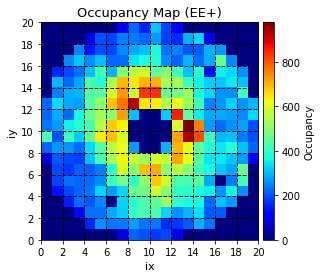

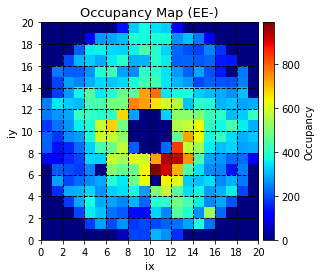

In [19]:
# Occupancy 
plot_2D(occupancy['p'][0], title = 'Occupancy Map (EE+)', label = 'Occupancy', doSave=True, figName='{}/EE+_Occupancy_bf_PU_Correction'.format(figOutDir))
plot_2D(occupancy['m'][0], title = 'Occupancy Map (EE-)', label = 'Occupancy', doSave=True, figName='{}/EE-_Occupancy_bf_PU_Correction'.format(figOutDir))

#### For All Run Files: PU vs. Lumi, Total Occupancy vs. PU, Total Occupancy vs. Lumi

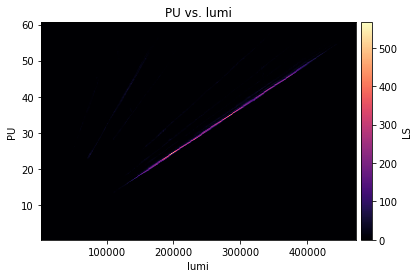

In [20]:
# PU vs. lumi
plot_density(lumi, PU, xlabel = 'lumi', ylabel='PU', title='PU vs. lumi', zlabel='LS')

plt.savefig('{}/PUvsLumi_bf_PU_Correction.png'.format(figOutDir))

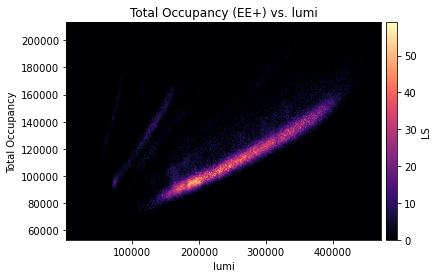

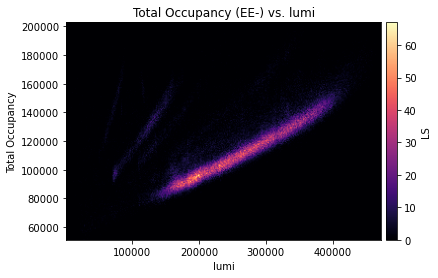

In [21]:
# Total occupancy vs. lumi
plot_density(lumi, occupancy_sum['p'], xlabel='lumi', ylabel='Total Occupancy', title='Total Occupancy (EE+) vs. lumi', zlabel='LS')
plt.savefig('{}/EE+_TotalOccupancy_vs_Lumi_bf_PU_Correction.png'.format(figOutDir))

plot_density(lumi, occupancy_sum['m'], xlabel='lumi', ylabel='Total Occupancy', title='Total Occupancy (EE-) vs. lumi', zlabel='LS')
plt.savefig('{}/EE-_TotalOccupancy_vs_Lumi_bf_PU_Correction.png'.format(figOutDir))

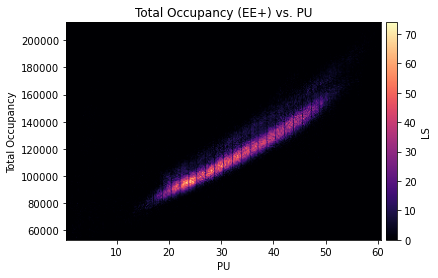

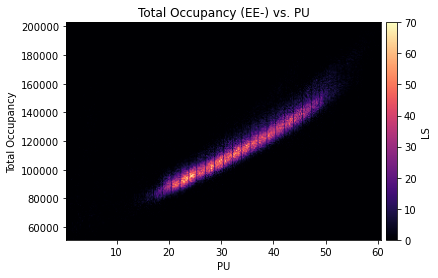

In [22]:
# Total occupancy vs. PU
plot_density(PU, occupancy_sum['p'], xlabel='PU', ylabel='Total Occupancy', title='Total Occupancy (EE+) vs. PU', zlabel='LS')
plt.savefig('{}/EE+_TotalOccupancy_vs_PU_after_PU_Correction.png'.format(figOutDir))

plot_density(PU, occupancy_sum['m'], xlabel='PU', ylabel='Total Occupancy', title='Total Occupancy (EE-) vs. PU', zlabel='LS')
plt.savefig('{}/EE-_TotalOccupancy_vs_PU_after_PU_Correction.png'.format(figOutDir))

We see here that PU is linearly related to the total occupancy (sum of the occupancies in all towers).

#### Linear regression on Total Occupancy vs. PU

In [23]:
# Linear regression on Total Occupancy vs. PU
fit = {'p': [], 'm': []} # fit parameters for EE+(p) and EE-(m)

fit['p'] = np.polyfit(PU, occupancy_sum['p'], 1)
fit['m'] = np.polyfit(PU, occupancy_sum['m'], 1)

print("Fit parameters")
print("EE+: {:.2f}, {:.2f}".format(fit['p'][0], fit['p'][1]))
print("EE-: {:.2f}, {:.2f}".format(fit['m'][0], fit['m'][1]))

Fit parameters
EE+: 2225.48, 44278.88
EE-: 2081.50, 45988.27


EE+ Fit parameters: 2225.48, 44278.88


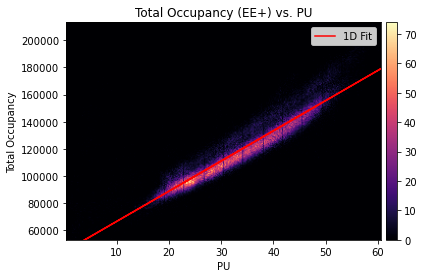

In [24]:
# Plot total occupancies vs. PU and linear fit for EE+ (p)
plot_density(PU, occupancy_sum['p'], xlabel='PU', ylabel='Total Occupancy', title='Total Occupancy (EE+) vs. PU')

plt.plot(PU, np.poly1d(fit['p'])(PU), label='1D Fit', color='red')

plt.legend()

plt.savefig('{}/EE+_TotalOccupancy_vs_PU_1DFit.png'.format(figOutDir))

print("EE+ Fit parameters: {:.2f}, {:.2f}".format(fit['p'][0], fit['p'][1]))

EE- Fit parameters: 2081.50, 45988.27


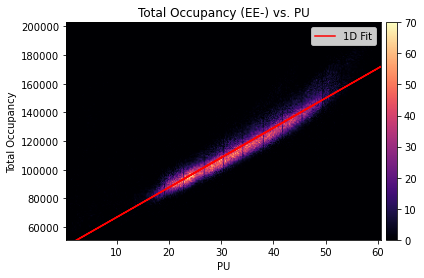

In [25]:
# Plot total occupancies vs. PU and linear fit for EE- (m)
plot_density(PU, occupancy_sum['m'], xlabel='PU', ylabel='Total Occupancy', title='Total Occupancy (EE-) vs. PU')

plt.plot(PU, np.poly1d(fit['m'])(PU), label='1D Fit', color='red')

plt.legend()

plt.savefig('{}/EE-_TotalOccupancy_vs_PU_1DFit.png'.format(figOutDir))

print("EE- Fit parameters: {:.2f}, {:.2f}".format(fit['m'][0], fit['m'][1]))

In [26]:
# Save as txt
PUdir = './PU_Correction/'
os.system('mkdir -p {}'.format(PUdir))

np.savetxt('{}EEp_PU_Correction_Factor.csv'.format(PUdir), fit['p'], delimiter=',')
np.savetxt('{}EEm_PU_Correction_Factor.csv'.format(PUdir), fit['m'], delimiter=',')

#### For each run era

In [27]:
# Linear regression on Total Occupancy vs. PU
fit_run = {'A': {'p': [], 'm': []}, 'B': {'p': [], 'm': []}, 'C': {'p': [], 'm': []}, 'D': {'p': [], 'm': []}}

for era, param in fit_run.items():
    fit_run[era]['p'] = np.polyfit(PU_run[era], occupancy_sum_run[era]['p'], 1)
    fit_run[era]['m'] = np.polyfit(PU_run[era], occupancy_sum_run[era]['m'], 1)
    print("\nRun {}: Fit parameters".format(era))
    print("EE+: {:.2f}, {:.2f}".format(fit_run[era]['p'][0], fit_run[era]['p'][1]))
    print("EE-: {:.2f}, {:.2f}".format(fit_run[era]['m'][0], fit_run[era]['m'][1]))


Run A: Fit parameters
EE+: 2289.70, 46055.89
EE-: 2156.97, 45434.14

Run B: Fit parameters
EE+: 2099.07, 46097.85
EE-: 1975.45, 46231.78

Run C: Fit parameters
EE+: 2075.44, 45241.42
EE-: 1954.68, 49592.35

Run D: Fit parameters
EE+: 2270.93, 41647.36
EE-: 2127.15, 46515.18


In [28]:
# Save as txt
for era, param in fit_run.items():
    np.savetxt('{}EEp_PU_Correction_Factor_Run{}.csv'.format(PUdir, era), fit_run[era]['p'], delimiter=',')
    np.savetxt('{}EEm_PU_Correction_Factor_Run{}.csv'.format(PUdir, era), fit_run[era]['m'], delimiter=',')

#### Normalize Occupancies by linear fit parameters from Total Occupancies vs. PU

In [29]:
# Apply PU correction to occupancy maps for all LS
# Then multiply by # of towers (20x20) to make the mean occupancy across the pixels 1.

def applyPUcorr(img, PU, fit):
    scale = fit[0]*PU+fit[1]

    # reshape the `scale` tensor if necessary to perform division with `img` tensor, to match the dimensions
    # -> if the img tensor has the size of e.g. [batch_size, 1, 20, 20] whereas PU has the size [batch_size, 1],
    # -> you need to reshape the PU tensor as [batch_size, 1, 1, 1] by adding the extra 2 dimensions
    # -> but if img and PU tensor have the same shape, you don't add any extra dimensions
    scaleShape = list(scale.shape)
    extraDim = [1]*(len(img.shape)-len(PU.shape)) # additional dimensions
    scaleShape += extraDim
    
    scale = scale.reshape(torch.Size(scaleShape))
    
    corrected = img / scale

    return 20*20*corrected

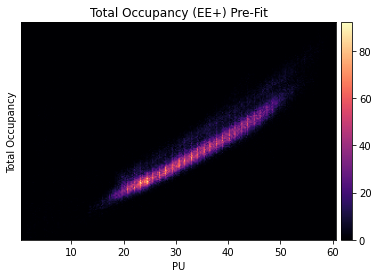

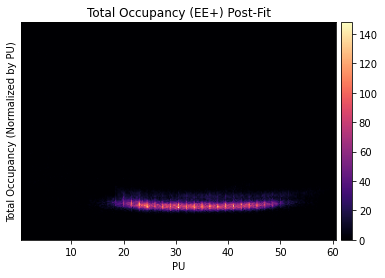

In [30]:
# EE+ (p)
occupancy_sum_norm = {'p': [], 'm': []}

# convert the lists to torch tensors to perform `applyPUcorr` as the fn is built for torch tensors
occupancy_sum_norm['p'] = applyPUcorr(torch.Tensor(occupancy_sum['p']), torch.Tensor(PU), torch.Tensor(fit['p'])).tolist()

plot_density(PU, occupancy_sum['p'], xlabel='PU', ylabel='Total Occupancy', title='Total Occupancy (EE+) Pre-Fit')
plt.plot('{}/EE+_TotalOccupancy_vs_PU_bf_PU_Correction.png'.format(figOutDir))

plot_density(PU, occupancy_sum_norm['p'], xlabel='PU', ylabel='Total Occupancy (Normalized by PU)', title='Total Occupancy (EE+) Post-Fit')
plt.plot('{}/EE+_TotalOccupancy_vs_PU_after_PU_Correction.png'.format(figOutDir))

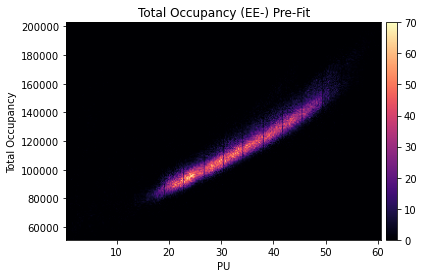

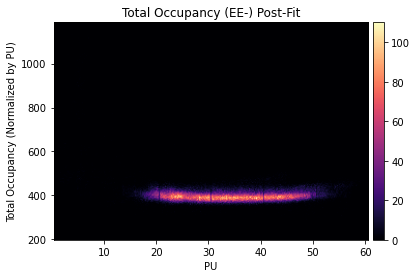

In [31]:
# EE- (m)
# convert the lists to torch tensors to perform `applyPUcorr` as the fn is built for torch tensors
occupancy_sum_norm['m'] = applyPUcorr(torch.Tensor(occupancy_sum['m']), torch.Tensor(PU), torch.Tensor(fit['m'])).tolist()

plot_density(PU, occupancy_sum['m'], xlabel='PU', ylabel='Total Occupancy', title='Total Occupancy (EE-) Pre-Fit')
plt.savefig('{}/EE-_TotalOccupancy_vs_PU_bf_PU_Correction.png'.format(figOutDir))

plot_density(PU, occupancy_sum_norm['m'], xlabel='PU', ylabel='Total Occupancy (Normalized by PU)', title='Total Occupancy (EE-) Post-Fit')
plt.savefig('{}/EE-_TotalOccupancy_vs_PU_after_PU_Correction.png'.format(figOutDir))

#### Apply PU corrections to occupancy maps 

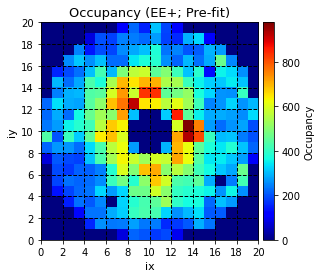

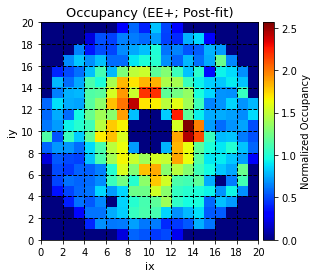

In [32]:
# For a single LS
plot_2D(occupancy['p'][0], title='Occupancy (EE+; Pre-fit)', label='Occupancy', doSave=True, figName='{}/EE+_Occupancy_bf_PU_Correction'.format(figOutDir))
plot_2D(applyPUcorr(occupancy['p'][0], np.array(PU[0]), fit['p']), title='Occupancy (EE+; Post-fit)', label='Normalized Occupancy', doSave=True, figName='{}/EE+_Occupancy_after_PU_Correction'.format(figOutDir))

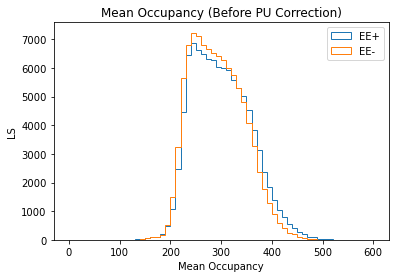

In [33]:
mean_occupancy = {'p': [], 'm': []}

for i in range(len(datasetAll)):
    mean_occupancy['p'].append(np.mean(occupancy['p'][i]))
    mean_occupancy['m'].append(np.mean(occupancy['m'][i]))
    
fig, ax = plt.subplots()

ax.hist(mean_occupancy['p'], bins=60, range=(0, 600), label='EE+', histtype='step', fill=False)
ax.hist(mean_occupancy['m'], bins=60, range=(0, 600), label='EE-', histtype='step', fill=False)

ax.set_xlabel('Mean Occupancy')
ax.set_ylabel('LS')
ax.set_title('Mean Occupancy (Before PU Correction)')

plt.legend()

plt.savefig('{}/MeanOccupancy_Hist_bf_PU_Correction'.format(figOutDir))

plt.show()

In [34]:
# Apply PU correction to occupancy maps for all LS

for i in range(len(datasetAll)):
    occupancy['p'][i] = applyPUcorr(occupancy['p'][i], PU[i], fit['p'])
    occupancy['m'][i] = applyPUcorr(occupancy['m'][i], PU[i], fit['m'])

In [35]:
mean_occupancy = {'p': [], 'm': []}

for i in range(len(datasetAll)):
    mean_occupancy['p'].append(np.mean(occupancy['p'][i]))
    mean_occupancy['m'].append(np.mean(occupancy['m'][i]))

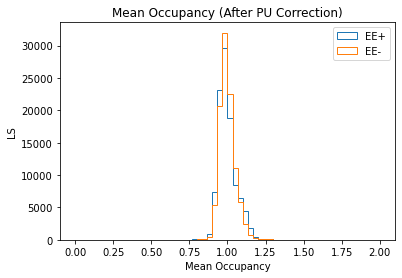

In [36]:
fig, ax = plt.subplots()

ax.hist(mean_occupancy['p'], bins=60, range=(0, 2), label='EE+', histtype='step', fill=False)
ax.hist(mean_occupancy['m'], bins=60, range=(0, 2), label='EE-', histtype='step', fill=False)

ax.set_xlabel('Mean Occupancy')
ax.set_ylabel('LS')
ax.set_title('Mean Occupancy (After PU Correction)')

plt.legend()

plt.savefig('{}/MeanOccupancy_Hist_after_PU_Correction'.format(figOutDir))

plt.show()

#### For each run era

In [37]:
# Apply PU correction to occupancy maps for each era

for era, param in fit_run.items():
    for i in range(len(dataset[era])):
        occupancy_run[era]['p'][i] = applyPUcorr(occupancy_run[era]['p'][i], PU_run[era][i], fit_run[era]['p'])
        occupancy_run[era]['m'][i] = applyPUcorr(occupancy_run[era]['m'][i], PU_run[era][i], fit_run[era]['m'])

#### Get average occupancy map across all LS

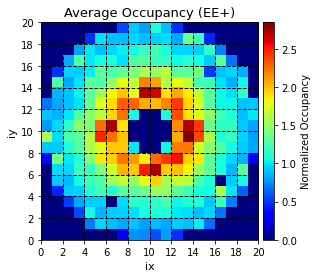

Mean occupancy of this image: 1.00


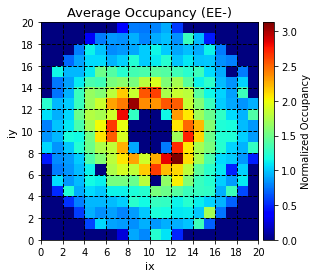

Mean occupancy of this image: 1.00


In [38]:
avg_occupancy = {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}

for i in range(len(datasetAll)):
    avg_occupancy['p'] += occupancy['p'][i]
    avg_occupancy['m'] += occupancy['m'][i]

avg_occupancy['p'] /= len(datasetAll)
avg_occupancy['m'] /= len(datasetAll)
    
plot_2D(avg_occupancy['p'], title='Average Occupancy (EE+)', label='Normalized Occupancy', doSave=True, figName='{}/EE+_AvgOccupancy_after_PU_Correction'.format(figOutDir))
print('Mean occupancy of this image: {:.2f}'.format(np.mean(avg_occupancy['p'])))
plot_2D(avg_occupancy['m'], title='Average Occupancy (EE-)', label='Normalized Occupancy', doSave=True, figName='{}/EE-_AvgOccupancy_after_PU_Correction'.format(figOutDir))
print('Mean occupancy of this image: {:.2f}'.format(np.mean(avg_occupancy['m'])))

In [39]:
# save to csv file
avg_occ_dir = './Avg_Occupancy/'
os.system('mkdir -p {}'.format(avg_occ_dir))

np.savetxt('{}avg_occupancy_EEp.csv'.format(avg_occ_dir), avg_occupancy['p'], delimiter=',')
np.savetxt('{}avg_occupancy_EEm.csv'.format(avg_occ_dir), avg_occupancy['m'], delimiter=',')

#### For each run era


Run A


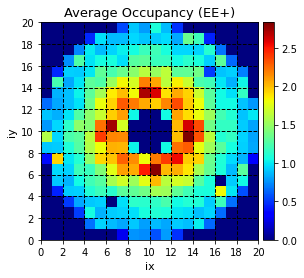

Mean occupancy of this image: 1.001


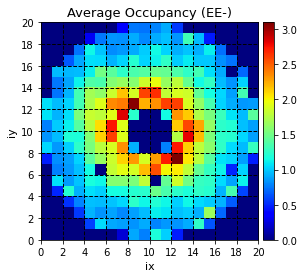

Mean occupancy of this image: 1.001

Run B


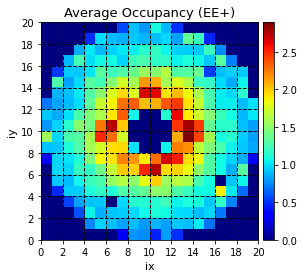

Mean occupancy of this image: 1.001


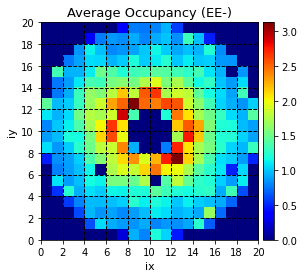

Mean occupancy of this image: 1.001

Run C


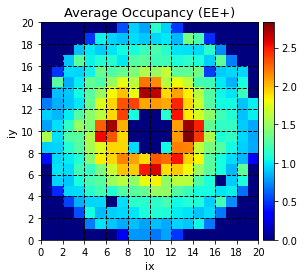

Mean occupancy of this image: 1.001


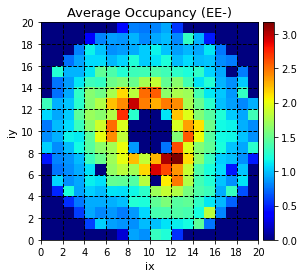

Mean occupancy of this image: 1.001

Run D


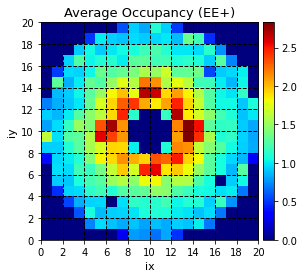

Mean occupancy of this image: 1.001


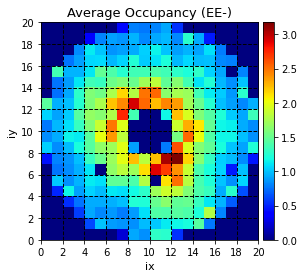

Mean occupancy of this image: 1.001


In [40]:
# Get avg occupancy for each run era
avg_occupancy_run = {'A': {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}, 'B': {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}, 'C': {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}, 'D': {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}}

for era in ['A', 'B', 'C', 'D']:
    for i in range(len(dataset[era])):
        avg_occupancy_run[era]['p'] += occupancy_run[era]['p'][i]
        avg_occupancy_run[era]['m'] += occupancy_run[era]['m'][i]

    avg_occupancy_run[era]['p'] /= len(dataset[era])
    avg_occupancy_run[era]['m'] /= len(dataset[era])
    
    print('\nRun {}'.format(era))
    plot_2D(avg_occupancy_run[era]['p'], title='Average Occupancy (EE+)')
    print('Mean occupancy of this image: {:.3f}'.format(np.mean(avg_occupancy_run[era]['p'])))
    plot_2D(avg_occupancy_run[era]['m'], title='Average Occupancy (EE-)')
    print('Mean occupancy of this image: {:.3f}'.format(np.mean(avg_occupancy_run[era]['m'])))

In [41]:
# save to csv file
for era in ['A', 'B', 'C', 'D']:
    np.savetxt('{}avg_occupancy_EEp_Run{}.csv'.format(avg_occ_dir, era), avg_occupancy_run[era]['p'], delimiter=',')
    np.savetxt('{}avg_occupancy_EEm_Run{}.csv'.format(avg_occ_dir, era), avg_occupancy_run[era]['m'], delimiter=',')

In [42]:
# Get avg occupancy for each run era
avg_occupancy_AtoB = {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}
avg_occupancy_AtoC = {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}

for i in range(len(dataset['A'])):
    avg_occupancy_AtoB['p'] += occupancy_run['A']['p'][i]
    avg_occupancy_AtoB['m'] += occupancy_run['A']['m'][i]
    
    avg_occupancy_AtoC['p'] += occupancy_run['A']['p'][i]
    avg_occupancy_AtoC['m'] += occupancy_run['A']['m'][i]
    
for i in range(len(dataset['B'])):
    avg_occupancy_AtoB['p'] += occupancy_run['B']['p'][i]
    avg_occupancy_AtoB['m'] += occupancy_run['B']['m'][i]
    
    avg_occupancy_AtoC['p'] += occupancy_run['B']['p'][i]
    avg_occupancy_AtoC['m'] += occupancy_run['B']['m'][i]

for i in range(len(dataset['C'])):
    avg_occupancy_AtoC['p'] += occupancy_run['C']['p'][i]
    avg_occupancy_AtoC['m'] += occupancy_run['C']['m'][i]
    
avg_occupancy_AtoB['p'] /= (len(dataset['A'])+len(dataset['B']))
avg_occupancy_AtoB['m'] /= (len(dataset['A'])+len(dataset['B']))

avg_occupancy_AtoC['p'] /= (len(dataset['A'])+len(dataset['B'])+len(dataset['C']))
avg_occupancy_AtoC['m'] /= (len(dataset['A'])+len(dataset['B'])+len(dataset['C']))

In [43]:
# save to csv file
np.savetxt('{}avg_occupancy_EEp_RunAtoB.csv'.format(avg_occ_dir), avg_occupancy_AtoB['p'], delimiter=',')
np.savetxt('{}avg_occupancy_EEm_RunAtoB.csv'.format(avg_occ_dir), avg_occupancy_AtoB['m'], delimiter=',')

np.savetxt('{}avg_occupancy_EEp_RunAtoC.csv'.format(avg_occ_dir), avg_occupancy_AtoC['p'], delimiter=',')
np.savetxt('{}avg_occupancy_EEm_RunAtoC.csv'.format(avg_occ_dir), avg_occupancy_AtoC['m'], delimiter=',')

## Pre-processing #2: Remove Invalid Towers from the Map

Later during validation when we apply "fake anomalies (dead tower or hot tower)" to the occupancy map, we want to apply the fake anomalies to the "good towers". In other words, we want to apply fake anomalies to valid towers: if we apply the fake anomaly to a tower that is already problematic (with anomalies that are known throughout the run), or to a pixel in the 20x20 occupancy map that is not a physical tower at all, then we would not really be applying the fake anomaly at all. 

For this purpose, we make a list of "valid" towers, removing the "invalid" towers (pixels) from the occupancy map. The invalid towers include the following:
1. Pixels of the towers that correspond to the towers with the known issues from Run 2018. We could get the information of which towers these are from the `channel status map` below. 
2. Pixels in the 20x20 map that do not correspond to physical towers. We could get the information of these using the average occupancy map above. If the occupancy of the pixel is 0 in the average occupancy map, we tag the pixel as non-tower pixel (not a physical tower).

#### Process the channel status maps, to get the coordinates of the problematic towers

<img src="../Run325170_EE_channelStatusMap.png" width=70% style="float:left"/>

In [44]:
fmap = pq.ParquetFile('../DATA/500ev_EE_channelstatusmap_run319993.parquet')

In [45]:
#fmap.schema

In [46]:
status = {'p': [], 'm': []}

# EE+
status['p'] = fmap.read_row_group(0,columns=['EEIntegrityClient_EEIT_EE_p_channel_status_map.list.item']).to_pydict()['EEIntegrityClient_EEIT_EE_p_channel_status_map'][0]
status['p'] = np.array(status['p'])

# EE-
status['m'] = fmap.read_row_group(0,columns=['EEIntegrityClient_EEIT_EE_m_channel_status_map.list.item']).to_pydict()['EEIntegrityClient_EEIT_EE_m_channel_status_map'][0]
status['m'] = np.array(status['m'])

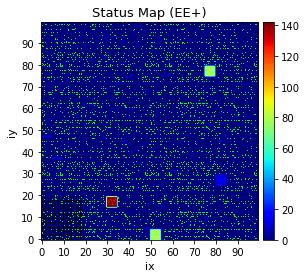

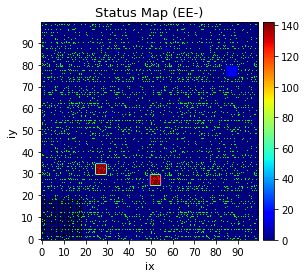

In [47]:
# EE+
plot_2D(status['p'], title = 'Status Map (EE+)', doTick=False)

# EE-
plot_2D(status['m'], title = 'Status Map (EE-)', doTick=False)

In [48]:
# Apply threshold to crystals (Assign boolean -- "Good" crystal: 0, "Bad" crystal: 1)
for iy in range(100):
    for ix in range(100):
        if status['p'][iy][ix] != 0:
            status['p'][iy][ix] = 1
        if status['m'][iy][ix] != 0:
            status['m'][iy][ix] = 1

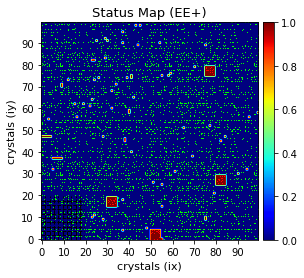

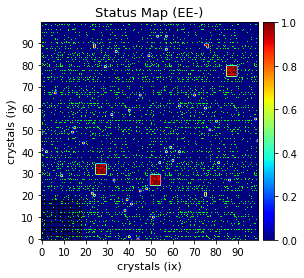

In [49]:
plot_2D(status['p'], title = 'Status Map (EE+)', xlabel='crystals (ix)', ylabel='crystals (iy)', doTick=False)
plot_2D(status['m'], title = 'Status Map (EE-)', xlabel='crystals (ix)', ylabel='crystals (iy)', doTick=False)

In [50]:
# Rebin by 5x5 crystals
status['p'] = block_reduce(status['p'], block_size=(5,5), func=np.sum)
status['m'] = block_reduce(status['m'], block_size=(5,5), func=np.sum)

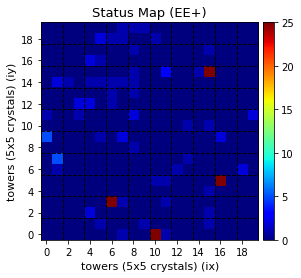

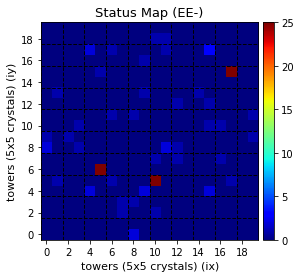

In [51]:
plot_2D(status['p'], title = 'Status Map (EE+)', xlabel='towers (5x5 crystals) (ix)', ylabel='towers (5x5 crystals) (iy)', doTick=False)
plot_2D(status['m'], title = 'Status Map (EE-)', xlabel='towers (5x5 crystals) (ix)', ylabel='towers (5x5 crystals) (iy)', doTick=False)

In [52]:
# Apply threshold to towers (Assign boolean -- "Good" crystal: 0, "Bad" crystal: 1)
thres = 4

for iy in range(20):
    for ix in range(20):
        if status['p'][iy][ix] > thres:
            status['p'][iy][ix] = 1
        else:
            status['p'][iy][ix] = 0
        if status['m'][iy][ix] > thres:
            status['m'][iy][ix] = 1
        else:
            status['m'][iy][ix] = 0

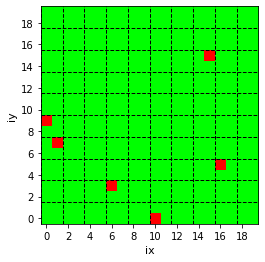

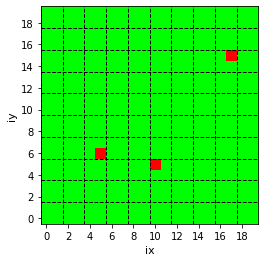

In [53]:
plot_2D(status['p'], doColorbar=False, xlabel='ix', ylabel='iy', doTick=False)
plot_2D(status['m'], doColorbar=False, xlabel='ix', ylabel='iy', doTick=False)

#### Make a list of valid towers

In [54]:
validIndex = {'p': [], 'm': []}
isValid = {'p': np.zeros_like(status['p']), 'm': np.zeros_like(status['m'])}

non_zero_occup_tower = {'p': [], 'm': []}

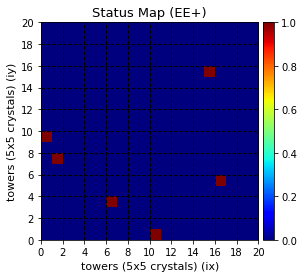

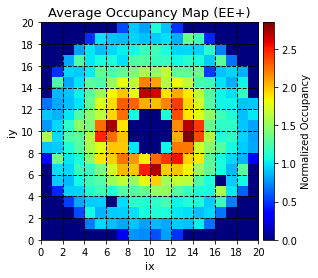

Number of valid towers (EE+): 306


In [55]:
# Get the list of valid towers of EE+
plot_2D(status['p'], title = 'Status Map (EE+)', xlabel='towers (5x5 crystals) (ix)', ylabel='towers (5x5 crystals) (iy)')
plot_2D(avg_occupancy['p'], title = 'Average Occupancy Map (EE+)', label = 'Normalized Occupancy')

# Mask the towers that either have 0 occupancies in the avg occupancy map or are labeled as anomaly towers from the channel status map
non_zero_occup_tower['p'] = np.array(avg_occupancy['p'] > 0)

isValid['p'] = np.logical_and(non_zero_occup_tower['p'], np.array(status['p'] != 1.0))
validIndex['p'] = np.argwhere(isValid['p']).tolist()

non_zero_occup_tower['p'] = np.argwhere(non_zero_occup_tower['p']).tolist()

print('Number of valid towers (EE+): {}'.format(len(validIndex['p'])))


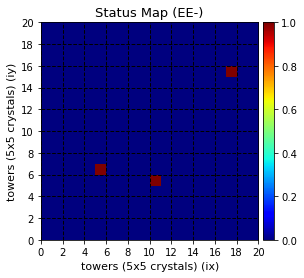

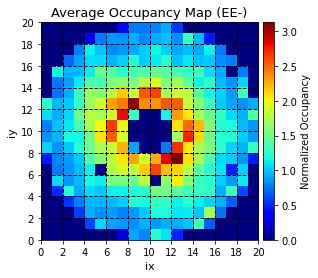

Number of valid towers (EE-): 309


In [56]:
# Get the list of valid towers of EE+
plot_2D(status['m'], title = 'Status Map (EE-)', xlabel='towers (5x5 crystals) (ix)', ylabel='towers (5x5 crystals) (iy)')
plot_2D(avg_occupancy['m'], title = 'Average Occupancy Map (EE-)', label = 'Normalized Occupancy')

# Mask the towers that either have 0 occupancies in the avg occupancy map or are labeled as anomaly towers from the channel status map
non_zero_occup_tower['m'] = np.array(avg_occupancy['m'] > 0)

isValid['m'] = np.logical_and(non_zero_occup_tower['m'], np.array(status['m'] != 1.0))
validIndex['m'] = np.argwhere(isValid['m']).tolist()

non_zero_occup_tower['m'] = np.argwhere(non_zero_occup_tower['m']).tolist()

print('Number of valid towers (EE-): {}'.format(len(validIndex['m'])))

In [57]:
isValid['p'] = torch.tensor(isValid['p'])
isValid['m'] = torch.tensor(isValid['m'])

# Make isValid tensor of size 32*20*20 and flatten it
isValid['p'] = torch.stack(32*[isValid['p']], dim=0).view(-1).tolist()
isValid['m'] = torch.stack(32*[isValid['m']], dim=0).view(-1).tolist()

valid_tower_dir = './Valid_Tower_List/'
os.system('mkdir -p {}'.format(valid_tower_dir))

# save to csv file
np.savetxt('{}valid_towers_EEp.csv'.format(valid_tower_dir), validIndex['p'], delimiter=',')
np.savetxt('{}valid_towers_EEm.csv'.format(valid_tower_dir), validIndex['m'], delimiter=',')